In [22]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from krxns.net_construction import construct_reaction_network, extract_compounds
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.networks import SuperMultiDiGraph
from krxns.cheminfo import draw_reaction
from IPython.display import SVG
import json
from scipy.stats import spearmanr
from itertools import chain
from collections import defaultdict
import ipywidgets as widgets
from ipywidgets import interact

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
whitelist_fn = "top_25_whitelist"
rxns_fn = "sprhea_240310_v3_mapped"
atom_lb = 0.2
multi_nodes = True
ds = 100
similarity = 'tanimoto'

In [26]:
# Load known reaction data
with open(filepaths['data'] / f"{rxns_fn}.json", 'r') as f:
    krs = json.load(f)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))

# Load coreactant whitelist
with open(filepaths['coreactants'] / f"{whitelist_fn}.json", 'r') as f:
    coreactant_whitelist = json.load(f)

analysis_dir = filepaths['results'] / "path_structural_variation" / rxns_fn 

# Load topk
with open(analysis_dir / f"topk_{similarity}_{whitelist_fn}_atom_lb_{int(atom_lb * 100)}p_multi_nodes_{multi_nodes}_ds_{ds}.json", 'r') as f:
    topks = str2int(json.load(f))

with open(analysis_dir / f"path_spearmans_{similarity}_{whitelist_fn}_atom_lb_{int(atom_lb * 100)}p_multi_nodes_{multi_nodes}_ds_{ds}.json", 'r') as f:
    path_spearmans = str2int(json.load(f))

with open(analysis_dir / f"path_similarities_to_target_{similarity}_{whitelist_fn}_atom_lb_{int(atom_lb * 100)}p_multi_nodes_{multi_nodes}_ds_{ds}.json", 'r') as f:
    path_sims = str2int(json.load(f))

kcs, smi2id = extract_compounds(krs) # Get known compounds

In [27]:
G = SuperMultiDiGraph()
edges, nodes = construct_reaction_network(
    operator_connections=op_cxns,
    similarity_connections=sim_cxn,
    side_counts=side_counts,
    reactions=krs,
    coreactant_whitelist=coreactant_whitelist,
    atom_lb=atom_lb,
    add_multi_mol_nodes=multi_nodes
)
G.add_nodes_from(nodes)
G.add_edges_from(edges)

print(G.number_of_nodes(), G.number_of_edges())

11785 22096


In [28]:
paths = G.shortest_path()

# Filter out self-paths
tmp = {}
for i in paths:
    destinations = {j: elt for j, elt in paths[i].items() if i != j}
    if destinations:
        tmp[i] = destinations
paths = tmp

<class 'networkx.utils.decorators.argmap'> compilation 4:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


In [29]:
path_lens = {}
for i in paths:
    for j in paths[i]:
        path_lens[(i, j)] = len(paths[i][j])

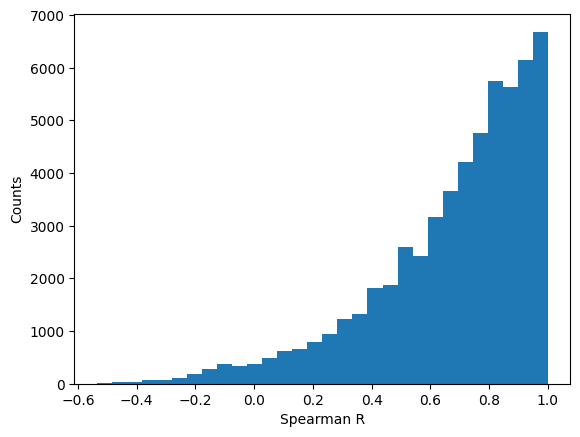

In [30]:
spearman_rs = list(chain(*[elt.values() for elt in path_spearmans.values()]))
fig, ax = plt.subplots()
ax.hist(spearman_rs, bins=30)
ax.set_ylabel("Counts")
ax.set_xlabel("Spearman R")
plt.show()

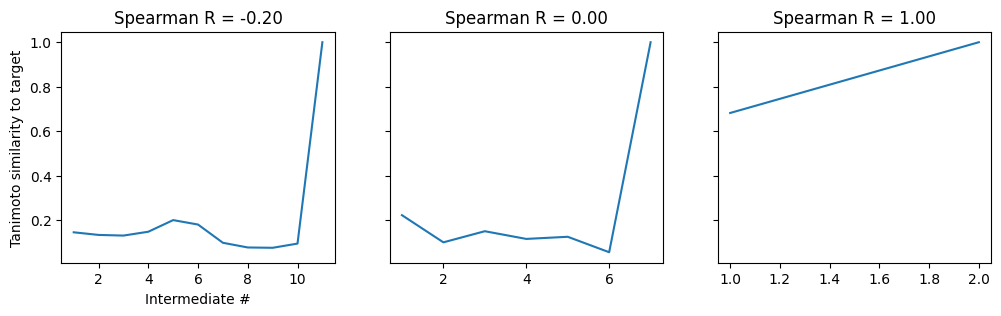

In [31]:
negative_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j] + 0.2) < 1e-4:
            negative_spearman_traces[(i, j)] = path_sims[i][j]

zero_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j]) < 1e-4:
            zero_spearman_traces[(i, j)] = path_sims[i][j]

one_spearman_traces = {}
for i in path_spearmans:
    for j in path_spearmans[i]:
        if abs(path_spearmans[i][j] - 1) < 1e-4:
            one_spearman_traces[(i, j)] = path_sims[i][j]

fig, ax = plt.subplots(ncols=3, figsize=(12, 3), sharey=True)

traces = [negative_spearman_traces, zero_spearman_traces, one_spearman_traces]

idx = 2
sts = [list(elt.keys())[min(idx, len(elt) - 1)] for elt in traces]

plot_it = lambda i, st : ax[i].plot(np.arange(1, len(traces[i][st]) + 1), traces[i][st])

for i, st in enumerate(sts):
    plot_it(i, st)
    s, t = st
    ax[i].set_title(f"Spearman R = {path_spearmans[s][t]:.2f}")

ax[0].set_ylabel(f"Tanimoto similarity to target")
ax[0].set_xlabel("Intermediate #")
plt.show()

In [34]:
def show_path(pair, topk = 1):
    source, target = pair
    overall = ">>".join((G.nodes[source]['smiles'], G.nodes[target]['smiles']))
    print("Overall: ".upper(), f"{G.nodes[source]['names']} >> {G.nodes[target]['names']}")
    print(f"Spearman: {path_spearmans[source][target]:.2f}")
    display(SVG(draw_reaction(overall)))
    node_path, edge_path = G.shortest_path(source, target, rm_req_target=False)
    for i, step in enumerate(edge_path):
        print(f"STEP #{i+1}")
        for edge in step[:topk]:
            print([(k, v) for k, v in edge.items() if k != 'smarts'])
            display(SVG(draw_reaction(edge['smarts'])))

In [35]:
options = [(i, pair) for i, pair in enumerate(sts)]
dd = widgets.Dropdown(options=options, value=options[0][1])

_ = interact(show_path, pair=dd)

interactive(children=(Dropdown(description='pair', options=((0, (4027, 10434)), (1, (766, 3293)), (2, (111, 26…

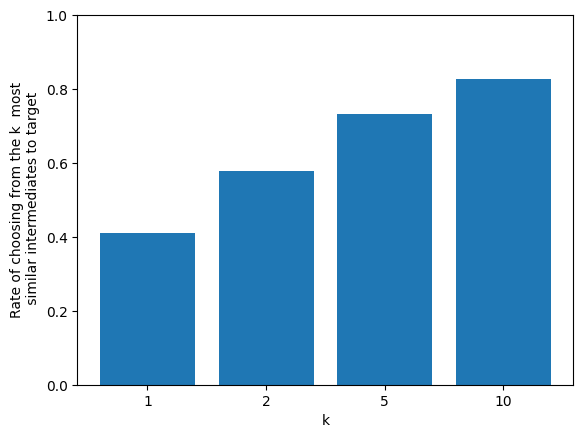

In [39]:
fig, ax = plt.subplots()
ax.bar([i for i in range(len(topks))], topks.values(), tick_label=topks.keys())
ax.set_ylim(0, 1)
ax.set_xlabel("k")
ax.set_ylabel("Rate of choosing from the k  most\n similar intermediates to target")
plt.show()


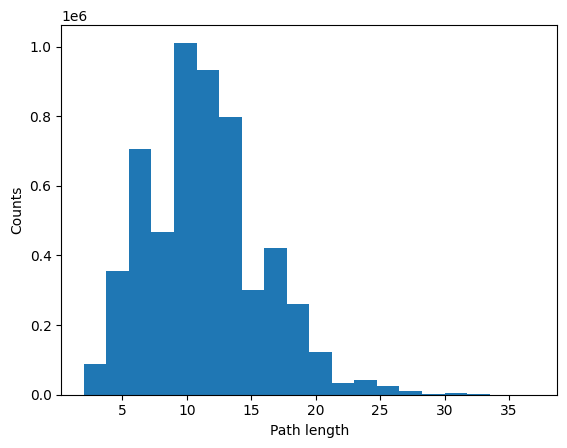

In [41]:
flat_lens = list(path_lens.values())
fig, ax = plt.subplots()
ax.hist(flat_lens, bins=20)
ax.set_ylabel("Counts")
ax.set_xlabel("Path length")
plt.show()

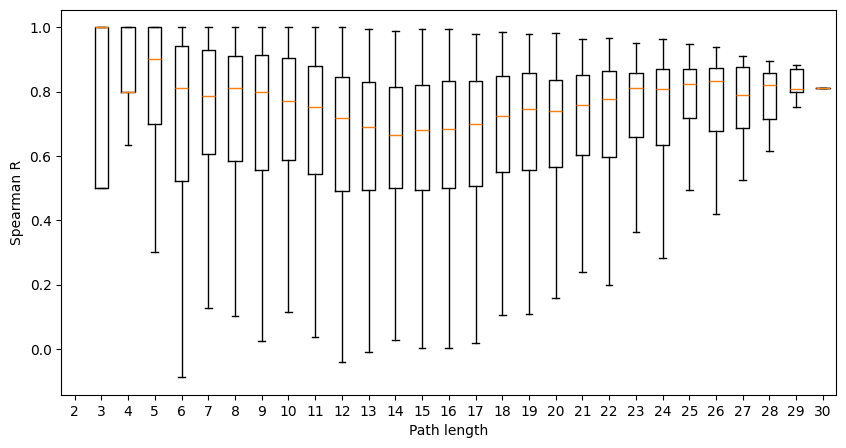

In [42]:
spearman_by_len = defaultdict(list)
for i in list(paths.keys())[::ds]:
    for j in paths[i]:
        plen = path_lens[(i, j)]
        r = path_spearmans[i][j]
        spearman_by_len[plen].append(r)

x = sorted(spearman_by_len.keys())
stats = []
box_data = []
for elt in x:
    scatter = np.array(spearman_by_len[elt])
    stats.append((scatter.mean(), scatter.std()))
    box_data.append(scatter)


mu, sig = zip(*stats)

fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot(box_data, positions=x, showfliers=False)
ax.set_ylabel("Spearman R")
ax.set_xlabel("Path length")
plt.show()


In [ ]:
# NOTE: this will have to change after change coreactant whitelist

import krxns
from collections import Counter
from itertools import product
def count_coreactant_debts(edge_path: list, coreactant_whitelist: dict):
    paths = product(*edge_path) # Get all possible paths given multipath
    for path in paths:
        coreactant_counter = Counter()
        for step in path:
            for rct, stoich in step['requires'].items():
                if rct in coreactant_whitelist:
                    coreactant_counter[rct] -= stoich
                else:
                    print(f"{rct} found not in whitelist...")
            for pdt, stoich in step['other_products'].items():
                if pdt in coreactant_whitelist:
                    coreactant_counter[pdt] += stoich
                

        # print(coreactant_counter)
        # debts = {}
        # counted_other = set()
        # for smi in sorted(coreactant_counter.keys()):
        #     if smi in counted_other:
        #         continue
        #     else:



_, edge_path = G.shortest_path(0, 8735)
count_coreactant_debts(edge_path, coreactant_whitelist)


